In [23]:
# !pip install opencv-python
# !pip install moviepy
!pip install graphviz 


     ---------------------------------------- 47.0/47.0 kB 2.3 MB/s eta 0:00:00


In [3]:
import os
import cv2
import math
# import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models.video as models
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Concatenate
from keras import backend as K
from keras.layers import BatchNormalization

In [4]:
# Experiment on pre-trained models
from keras.applications.efficientnet import EfficientNetB0,EfficientNetB7
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50, ResNet101, ResNet152
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [6]:
seed = 23
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

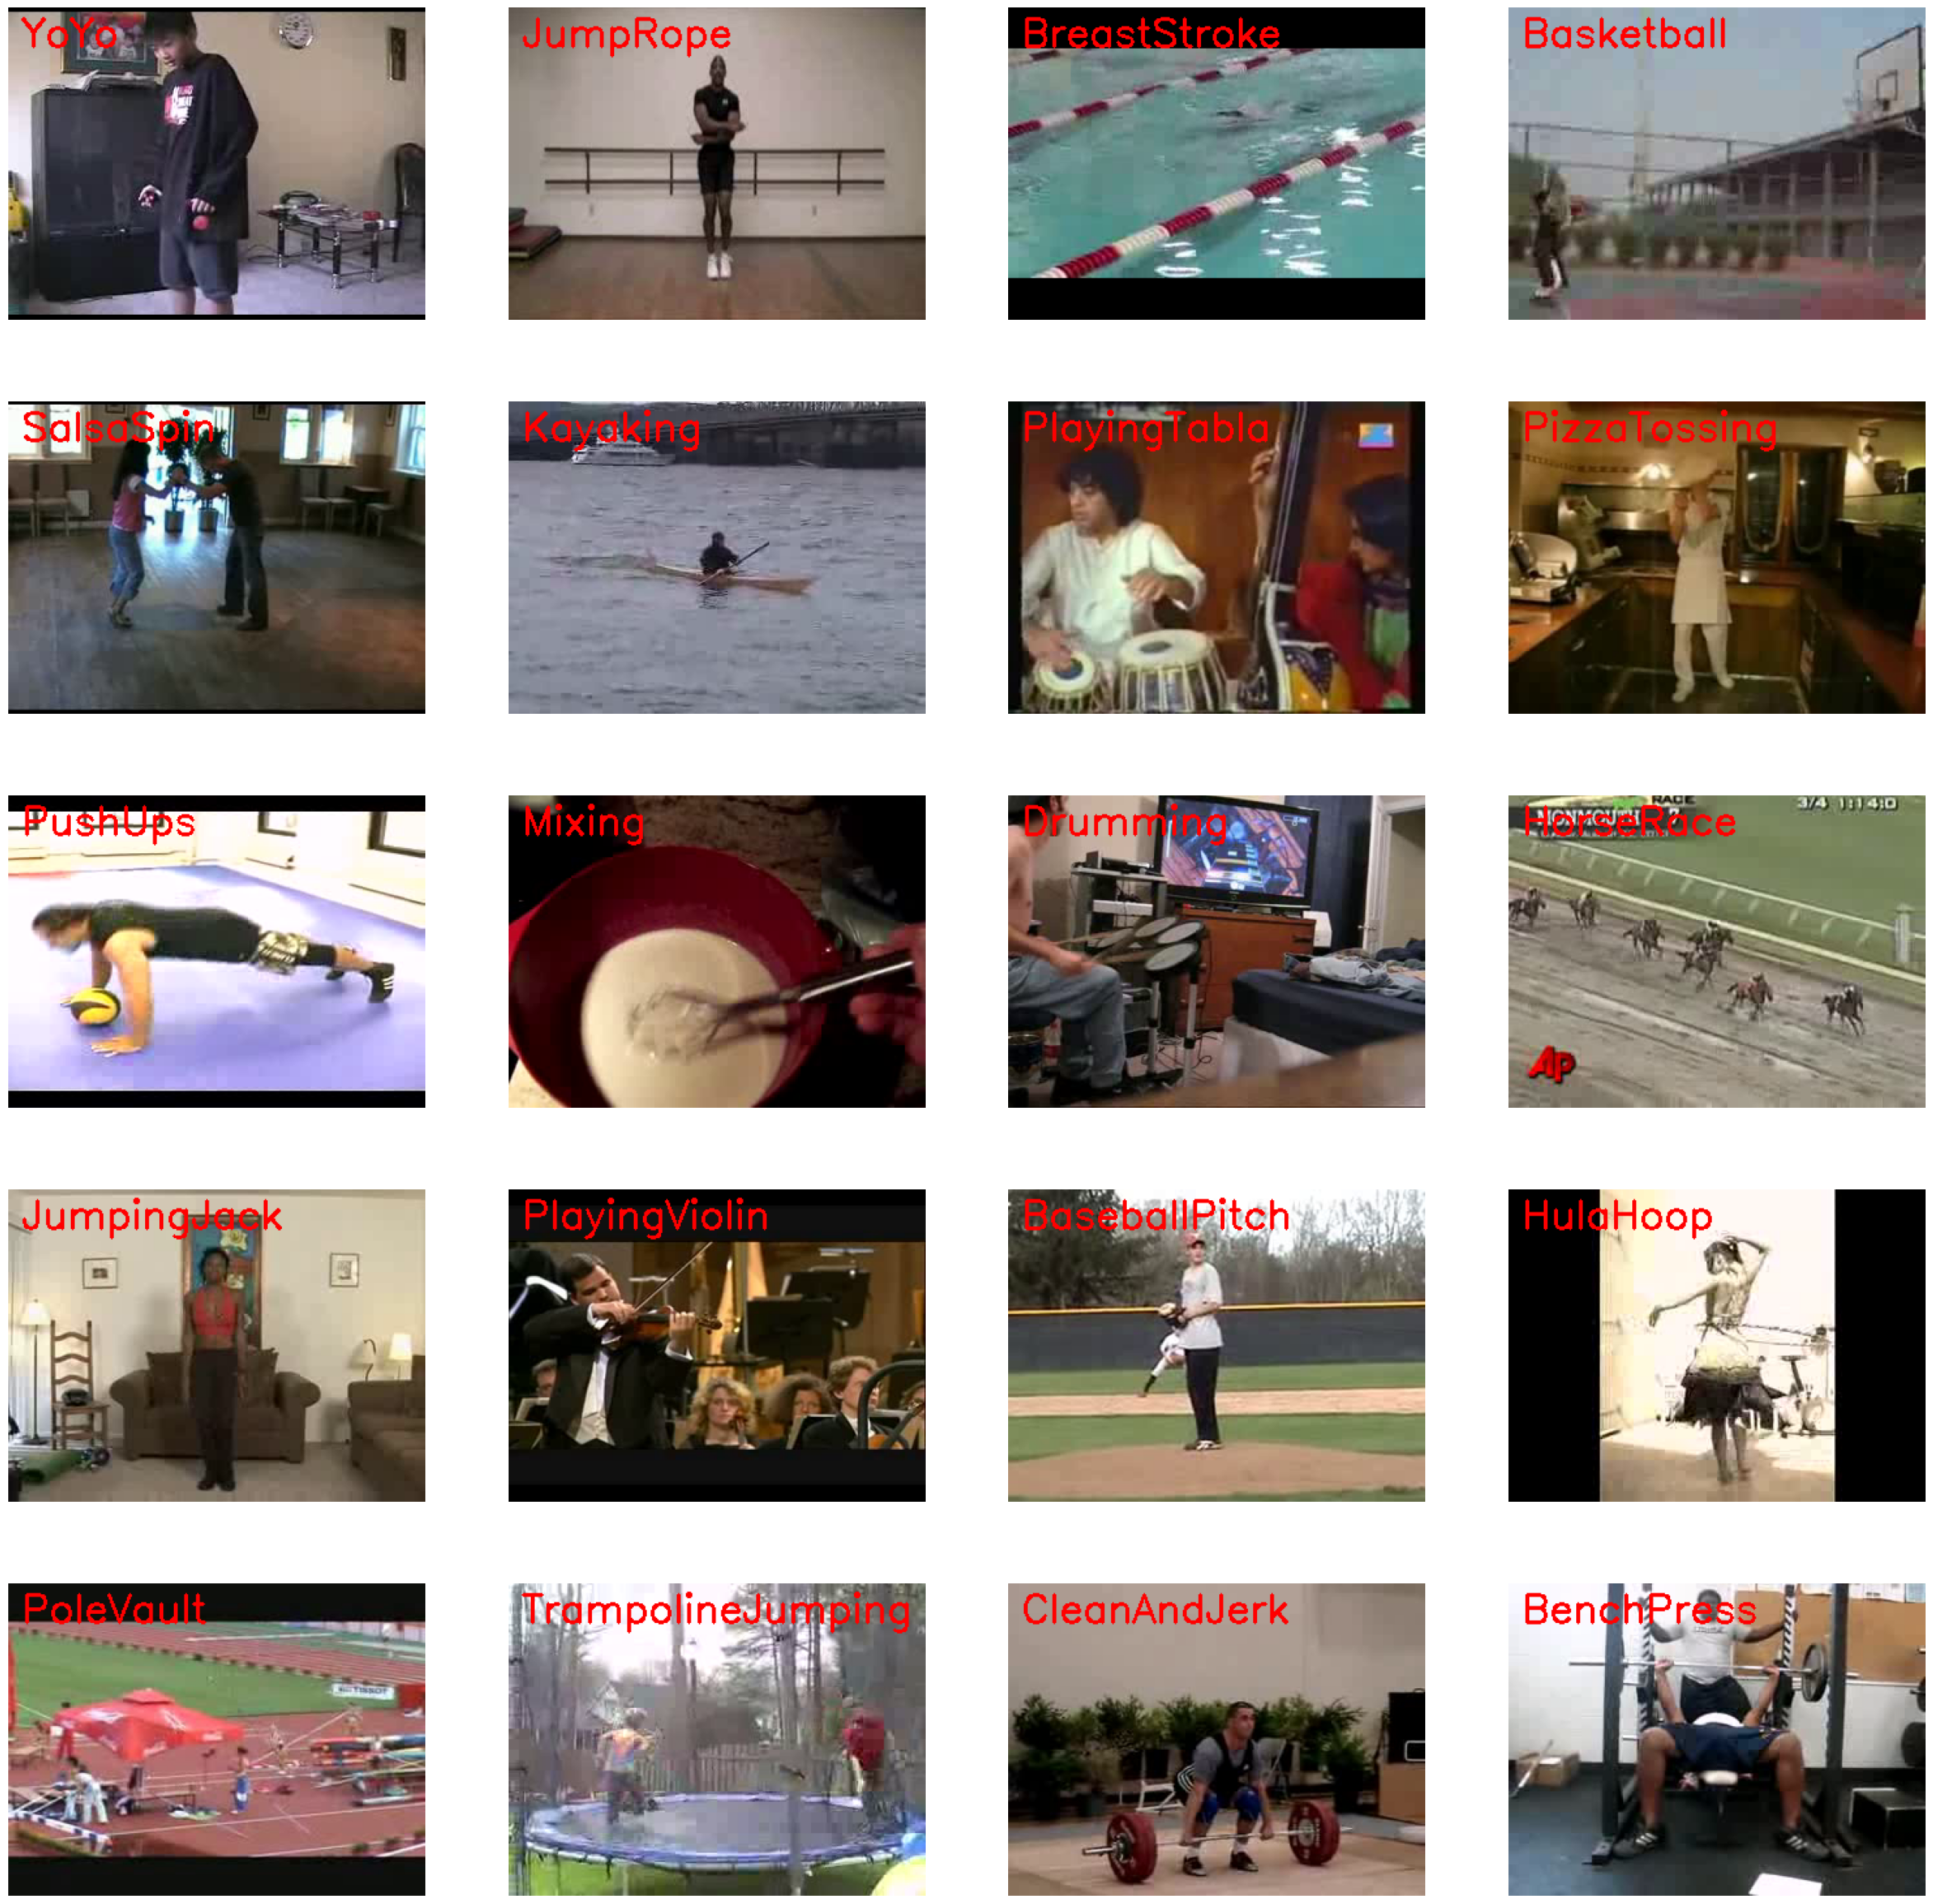

In [7]:
# Create a Matplotlib figure
plt.figure(figsize = (30, 30))
 
# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')
 
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)
 
# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
 
    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]
 
    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
 
    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
     
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()
 
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()
 
    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
     
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [8]:
len(all_classes_names)


50

To reduce the size of computation and given the information cantained in a video is consistant for consecatuive time length (each shard is around 5s(change later) ) 

The size of frames picked IS EXPERIMENT

Maybe check the average length of a shard (EDA)

In [9]:
IMG_HEIGHT, IMG_WIDTH = 64, 64

# Specifying the sequence of data to be feed to LSTM
# If for a video of 5 sec I have 25fps then I will choose 30 frames from the 125 frames sampled uniformly
# Increasing the sequence length will increase the accuracy but also will increase the computation cost
SEQUENCE_LENGTH = 30

DATASET_DIR = 'UCF50'

# Choose the classes that we will be used to classify
CLASSES_LIST = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

In [10]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = [] # stores the frames
    video_reader = cv2.VideoCapture(video_path) # read video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) # get the frames in that video
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1) # find skip interval length

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter*skip_frames_window) # set current frame position of video
        success, frame = video_reader.read() # read frame

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH)) # resize the frame
        
        normalized_frame = resized_frame / 255 # normalize the frame
        
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [11]:
dog = os.listdir(os.path.join(DATASET_DIR, 'WalkingWithDog')) # get list of video files present for that class
frames = frames_extraction(dog[0]) # extract frames from that video
frames

[]

Maybe can add data preparation (rotation, )

In [12]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting data of class:{class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name)) # get list of video files present for that class
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name) # get complete path

            frames = frames_extraction(video_file_path) # extract frames from that video

            # if the choosen video has frames == SEQUENCE_LENGTH
            # then add it to the features list else skip the video

            if(len(frames)==SEQUENCE_LENGTH):
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths

In [13]:
features, labels, video_files_paths = create_dataset()


Extracting data of class:WalkingWithDog
Extracting data of class:TaiChi
Extracting data of class:Swing
Extracting data of class:HorseRace
Extracting data of class:Kayaking


In [14]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [15]:
one_hot_encoded_labels = to_categorical(labels)
one_hot_encoded_labels


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [16]:
f_train, f_test, l_train, l_test = train_test_split(features, one_hot_encoded_labels,
                                                   test_size = 0.25, shuffle = True,
                                                   random_state = seed)

In [17]:
l_train.sum()

483.0

In [18]:
def create_convlstm_model():
    model = Sequential()
    
    # Model architecture
    # -------------------------------------------------------------------------------------------------------
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, 
                        input_shape = (SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3), 
                        return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation  = 'tanh',data_format = 'channels_last',
                        recurrent_dropout=0.2, return_sequences = True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding = 'same', data_format='channels_last'))
    
    model.add(Flatten())
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    # -------------------------------------------------------------------------------------------------------
    # Print model summary
    model.summary()
    
    return model

In [19]:
conv_lstm = create_convlstm_model()

print("Model creation successful")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 30, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 30, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 30, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 30, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 30, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [1]:
plot_model(conv_lstm, to_file='convlstm_model_architecture.png',
          show_shapes=True, show_layer_names = True)

NameError: name 'plot_model' is not defined

For the graph above, use the graph on the website directly

In [ ]:
import torch
import torch.nn as nn
import torchvision.models.video as models

class SlowFastLSTM(nn.Module):
    def __init__(self, num_classes):
        super(SlowFastLSTM, self).__init__()

        # Load the SlowFast feature extractor
        self.slowfast = models.slowfast.resnet50(pretrained=True, progress=True)

        # Replace the last fully-connected layer with an identity layer
        self.slowfast.head.fc = nn.Identity()

        # Define the ConvLSTM2D layers
        self.conv_lstm_layers = nn.ModuleList([
            nn.ConvLSTM2d(in_channels=2048, hidden_channels=4, kernel_size=3, bias=True, padding=1),
            nn.MaxPool3d(kernel_size=(1, 2, 2), padding='same'),
            nn.Dropout3d(p=0.2),

            nn.ConvLSTM2d(in_channels=4, hidden_channels=8, kernel_size=3, bias=True, padding=1),
            nn.MaxPool3d(kernel_size=(1, 2, 2), padding='same'),
            nn.Dropout3d(p=0.2),

            nn.ConvLSTM2d(in_channels=8, hidden_channels=14, kernel_size=3, bias=True, padding=1),
            nn.MaxPool3d(kernel_size=(1, 2, 2), padding='same'),
            nn.Dropout3d(p=0.2),

            nn.ConvLSTM2d(in_channels=14, hidden_channels=16, kernel_size=3, bias=True, padding=1),
            nn.MaxPool3d(kernel_size=(1, 2, 2), padding='same'),
        ])

        # Add a linear layer for output classification
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        # Extract SlowFast features
        x = self.slowfast(x)['slow']

        # Reshape the features to match ConvLSTM2D input shape
        x = x.permute(0, 2, 1, 3, 4) # (batch_size, sequence_length, channel, height, width)
        x = x.unsqueeze(2) # (batch_size, sequence_length, 1, channel, height, width)

        # Pass features through ConvLSTM2D layers
        for layer in self.conv_lstm_layers:
            x = layer(x)

        # Flatten output and pass through linear layer for classification
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [67]:
%%time
# we can call Early Stopping Callback if we need
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# compile the model with loss as categorical_crossentropy

conv_lstm.compile(loss = 'categorical_crossentropy', optimizer='Adam',
                 metrics=['accuracy'])

# train the model
conv_lstm_train_hist = conv_lstm.fit(x = f_train, y = l_train, epochs = 50,
                                    batch_size = 5, shuffle = True, 
                                     validation_split=0.2, callbacks = [early_stopping_callback])

Epoch 1/50
78/78 [==============================] - 104s 1s/step - loss: 1.5925 - accuracy: 0.2150 - val_loss: 1.3420 - val_accuracy: 0.4330
Epoch 2/50
78/78 [==============================] - 97s 1s/step - loss: 1.4238 - accuracy: 0.3782 - val_loss: 1.4323 - val_accuracy: 0.3402
Epoch 3/50
78/78 [==============================] - 97s 1s/step - loss: 1.2569 - accuracy: 0.4741 - val_loss: 1.2253 - val_accuracy: 0.5773
Epoch 4/50
78/78 [==============================] - 98s 1s/step - loss: 1.0158 - accuracy: 0.6062 - val_loss: 0.9996 - val_accuracy: 0.6186
Epoch 5/50
78/78 [==============================] - 99s 1s/step - loss: 0.8634 - accuracy: 0.6865 - val_loss: 0.8856 - val_accuracy: 0.5876
Epoch 6/50
78/78 [==============================] - 99s 1s/step - loss: 0.6710 - accuracy: 0.7461 - val_loss: 0.8652 - val_accuracy: 0.6804
Epoch 7/50
78/78 [==============================] - 97s 1s/step - loss: 0.5680 - accuracy: 0.7798 - val_loss: 0.8508 - val_accuracy: 0.7010
Epoch 8/50
78/78 [=

KeyboardInterrupt: 

In [69]:
model_evaluation_history = conv_lstm.evaluate(f_test, l_test)

6/6 [==============================] - 1s 200ms/step - loss: 0.8552 - accuracy: 0.7516
